# Median Income by Quantile Over Time

The recovery from the recession has looked very different for the bottom earners and the top-earners. And it's been very different in Bridgeport than it was nationally. In order to illustrate this, we made a graphic to track the percent change in mean income for four groups:

* 1.A The bottom 20% of income-earners in Bridgeport
* 1.B The top 5% of income-earners in Bridgeport
* 2.A The bottom 20% of income-earners nationally
* 2.B The top 20% of income-earners nationally

### ACS API

The mean income for each of these groups is available from the Census API from 2012-2016. We want the 1 year version of the American Commmunity Survey. Details on the API use can be found here: https://www.census.gov/data/developers/data-sets/acs-1year.html

In [1]:
import pandas,json,urllib,re,numpy,time

# API base url
base = "https://api.census.gov/data/"

#
# B19081_001E = mean income for the bottom 20% of income earners
# B19081_006E = mean income for the top 5% of income earners
#
fields = ["B19081_001E","B19081_006E"]

# Build a url for the given year, geography type, code, and fields
def construct_quant_url(year,geo_type,geo_code,quants):
    url = base + str(year)
    
    # The url structure is different for 2016 than it is for the other years because ¯\_(ツ)_/¯
    if (year == 2016):
        url += "/acs"
    url += "/acs1?get="
    for q in quants:
        url += q+"&"
    url+= "for="+geo_type
    if geo_code!='':
        url+=(":"+geo_code)
    return(url)

# Request & load data from a url
def url_to_data(url):
    req = urllib.request.Request(url)
    res = urllib.request.urlopen(req)
    data = json.load(res)
    return data

# Gets the API data and formats it as a list of lists.
#
# Sample output for make_long_data(2012,2014,'us','',quants=fields)
#
# [['B19081_001E', 'B19081_006E', 'geo', 'year'],
# ['11361', '319918', '1', 2012],
# ['11544', '339950', '1', 2013],
# ['11859', '346522', '1', 2014]]
#
def make_long_data(min_year,max_year,geo_type,geo_code,quants):
    tar = [fields+["geo","year"]]
    for year in range(min_year,max_year+1):
        url = construct_quant_url(year,geo_type,geo_code,quants)
        new_row = url_to_data(url)[1]
        new_row.append(year)
        tar.append(new_row)
    return tar

# Get data for our fields 2012-2016, for Bridgeport's MSA -- fips code 14860
bridgeport_data = make_long_data(2012,2016,"metropolitan%20statistical%20area/micropolitan%20statistical%20area","14860",fields)

# Get data for our fields 2012-2016, nationally -- don't need a fips code
national_data = make_long_data(2012,2016,"us","",fields)

In [56]:
bp_df = pandas.DataFrame(bridgeport_data[1:],columns = bridgeport_data[0])
nat_df = pandas.DataFrame(national_data[1:],columns = national_data[0])

census_fields = {"B19081_001E":"20","B19081_006E":"95","HD01_VD02":"20","HD01_VD07":"95"}

bp_df = bp_df.rename(columns=census_fields)
nat_df = nat_df.rename(columns=census_fields)

In [50]:
bp_nat = bp_df[["20","95","year"]].join(nat_df[["20","95","year"]].set_index('year'),on='year',lsuffix="_BP", rsuffix="_US")
bp_nat

,20_BP,95_BP,year,20_US,95_US
0,15822,768432,2012,11361,319918
1,15817,781504,2013,11544,339950
2,16741,822518,2014,11859,346522
3,16544,777935,2015,12365,364563
4,18159,813869,2016,12691,378330


# Earlier Years

We want data going back to 2007. Luckily, the Census collected these numbers. Unluckily, they're not available through the API. We'll have to download it manually from American Fact Finder:

https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml

Go to the Advanced Search panel:
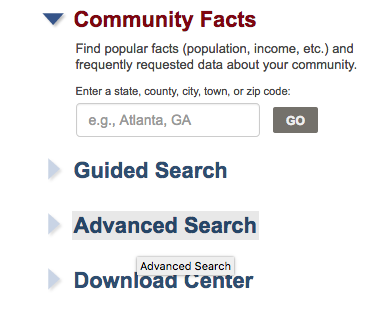

From there, search for table "B19081: MEAN HOUSEHOLD INCOME OF QUINTILES" and press "GO":
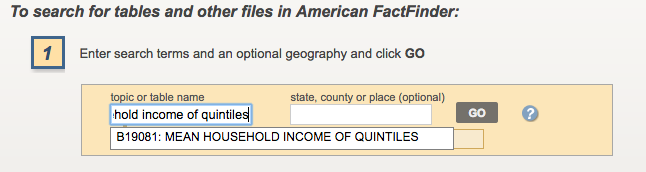

Then, filter the tables by Geography:
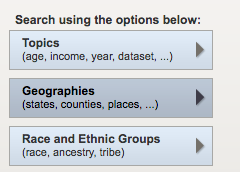

Select geographic type 310 (MSA) and then "Bridgeport-Stamford-Norwalk, CT" from that list, and add to your selections:
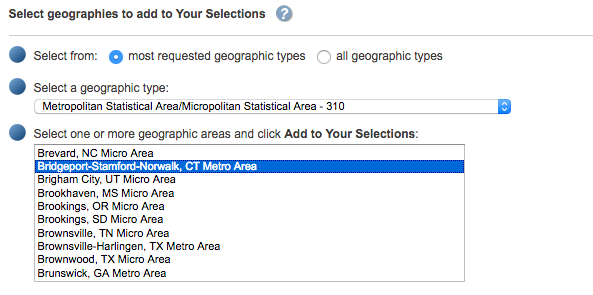

Select geographic type 10 (United States) and add to your selections:
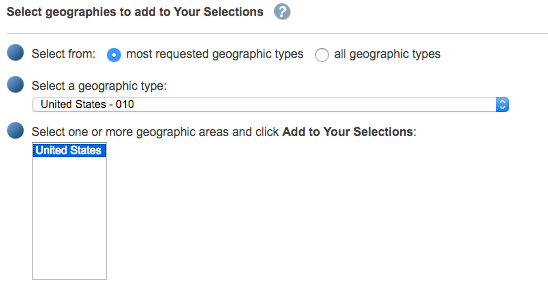

Select the *ACS 1-year estimates* for 2007 to 2011 and download them:
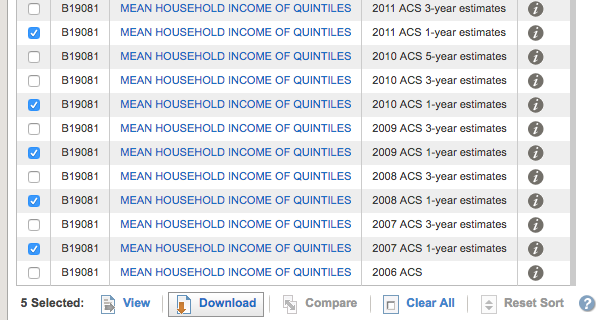

And put the zipped file "aff_download.zip" in the same directory as this notebook.

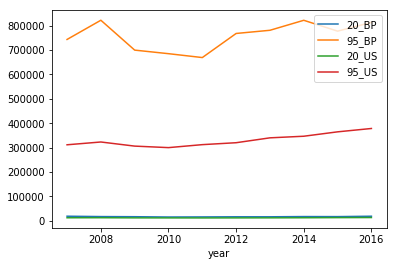

In [112]:
import zipfile,os

# Unzip the files and delete the ones we don't need (metadata and readmes)
def unzip_census(path,directory):
    zip_ref = zipfile.ZipFile(path)
    zip_ref.extractall(directory) 
    # Delete any files you don't want
    for filename in os.listdir(directory):
        if "_with_ann.csv" not in filename:
            os.remove(directory+"/"+filename)

# There isn't a year field in the files, so we need to extract them from the filenames
def get_year(filename):
    split = filename.split("_")
    return ("20"+split[1])          


# Get the data we need out of the unzipped files. A little hacky but it works!
def extract_data(directory,columns):
    bp = pandas.DataFrame({})
    nat = pandas.DataFrame({})
    for filename in os.listdir(directory):
        csv = pandas.read_csv(directory+"/"+filename)
        csv["year"] = get_year(filename)
        csv = csv.rename(columns=census_fields)[["year","GEO.id","GEO.id2","20","95"]]
        bp = pandas.concat([bp,csv[csv["GEO.id2"]=="14860"]])
        nat = pandas.concat([nat,csv[csv["GEO.id"]=="0100000US"]])
    
    bp_nat = bp[["20","95","year"]].join(nat[["20","95","year"]].set_index('year'),on='year',lsuffix="_BP", rsuffix="_US")
    return bp_nat
    
unzip_census("aff_download.zip","aff_download")
early_years = extract_data("aff_download","s")
bp_nat_all_years = pandas.concat([bp_nat,early_years])

# convert all data to numeric
columns = bp_nat_all_years.columns
bp_nat_all_years[columns] = bp_nat_all_years[columns].apply(lambda x: pandas.to_numeric(x))
bp_nat_all_years = bp_nat_all_years.sort_values("year")
bp_nat_all_years.set_index("year").plot()

### Inflation adjustment

Since we're looking at dollar amounts over time, we want to adjust our values for inflation. To do that we need to download the consumer price index data from the census: https://www.census.gov/topics/income-poverty/income/guidance/current-vs-constant-dollars.html

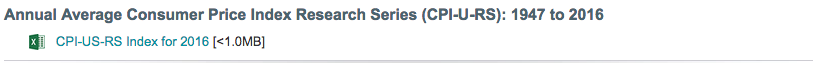

Move the file you download to the directory containing this notebook.

In [123]:
# Load CPI table
cpi = pandas.read_excel("CPI_U_RS.xlsx",header=2)

# It has a pretty unweildy column name by default, so let's change that
price_index = cpi.columns[1]
cpi = cpi.set_index("Year").rename(columns = {price_index:"cpi"})

# Join it to the rest of our data by year
to_adjust = bp_nat_all_years.join(cpi,on="year")
to_adjust

,20_BP,95_BP,year,20_US,95_US,cpi
2,18166,743831,2007,11797,311427,304.6
2,16701,822708,2008,11984,322881,316.3
2,16145,700068,2009,11467,305979,315.2
2,14933,685431,2010,11307,299770,320.3
2,15286,669517,2011,11186,311995,330.5
0,15822,768432,2012,11361,319918,337.3
1,15817,781504,2013,11544,339950,342.2
2,16741,822518,2014,11859,346522,347.8
3,16544,777935,2015,12365,364563,348.2
4,18159,813869,2016,12691,378330,352.6


These are the Census instructions on how to use the consumer price index:

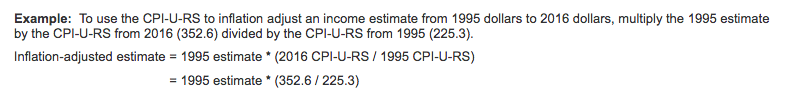

In [127]:
adjustable_cols = ["20_BP", "20_US", "95_BP", "95_US"]

# Make a dict with all the dollar values in the row
# adjusted to the dollars in the base year using consumer
# price index values
def adjust_dollars(row,base_cpi):
    factor = base_cpi/row["cpi"]
    tar = {}
    for x in adjustable_cols:
        tar[x] = row[x]*factor
    tar["year"] = row["year"]
    return tar

adjusted = to_adjust.copy()
adjusted["2016_dollars"] = adjusted.apply(lambda x: adjust_dollars(x,cpi.loc[2016]["cpi"]),axis=1)
sixteen_dollars = pandas.DataFrame(adjusted["2016_dollars"].tolist())

          20_BP         20_US          95_BP          95_US  year
0  21028.665791  13656.015102  861046.653316  360502.824032  2007
1  18617.681315  13359.337338  917125.642744  359936.264938  2008
2  18060.682107  12827.614848  783134.444162  342284.883883  2009
3  16438.887918  12447.231346  754551.890727  329999.694037  2010
4  16308.150076  11933.989713  714286.518003  332857.600605  2011
5  16539.689297  11876.337385  803288.239549  334429.548770  2012
6  16297.703682  11894.840444  805255.144360  350281.618936  2013
7  16972.043128  12022.666475  833869.599770  351304.362277  2014
8  16753.056864  12521.249282  787765.310167  369169.769673  2015
9  18159.000000  12691.000000  813869.000000  378330.000000  2016


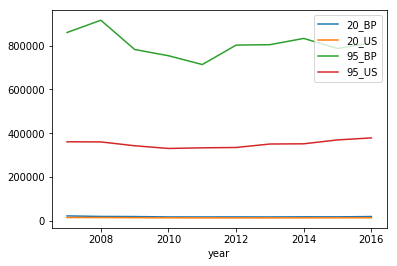

In [129]:
print(sixteen_dollars)
sixteen_dollars.set_index("year").plot()

### Convert from absolute to percent change since 2007

Now we're going to translate all of our data to the percent change in each series since 2007.

In [143]:
# Make a dict with all the dollar values in the row
# adjusted percent change since the value in the base year
def index(row,base_row):
    tar = {}
    for x in adjustable_cols:
        tar[x] = ((row[x]/base_row[x]) * 100) - 100
    tar["year"] = row["year"]
    return(tar)

base_index = sixteen_dollars.loc[0]
sixteen_dollars["index"] = sixteen_dollars.apply(lambda x: index(x,base_index),axis=1)

       20_BP      20_US      95_BP     95_US    year
0   0.000000   0.000000   0.000000  0.000000  2007.0
1 -11.465228  -2.172506   6.512886 -0.157158  2008.0
2 -14.113990  -6.066193  -9.048547 -5.053481  2009.0
3 -21.826291  -8.851658 -12.368060 -8.461274  2010.0
4 -22.448004 -12.610014 -17.044388 -7.668518  2011.0
5 -21.346939 -13.032189  -6.707931 -7.232475  2012.0
6 -22.497681 -12.896695  -6.479499 -2.835264  2013.0
7 -19.290918 -11.960653  -3.156281 -2.551564  2014.0
8 -20.332288  -8.309641  -8.510729  2.404127  2015.0
9 -13.646447  -7.066594  -5.479105  4.945086  2016.0


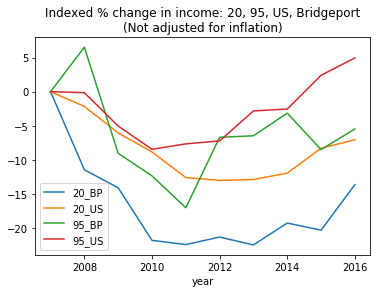

In [142]:
current_dollars_indexed = pandas.DataFrame(sixteen_dollars["index"].tolist())
print(current_dollars_indexed)
current_dollars_indexed.set_index("year").plot(title="Indexed % change in income: 20, 95, US, Bridgeport\n(Not adjusted for inflation)")